#### **1) Libraries**

In [1]:
# !pip install -U tensorflow_probability -q
!pip install -q ipdb

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

from tensorflow import keras
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose 

If using Google Colab, save in your Google Drive.

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **2) MNIST Data**

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [5]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

In [6]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [7]:
train_size = 60000
batch_size = 32
test_size = 10000

In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [9]:
print(train_dataset), print(test_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


(None, None)

#### **3) Model Class**

In [10]:
class VAEModel(tf.keras.Model):
    """Variational Autoencoder base model."""

    def __init__(self, latent_dim):
        super(VAEModel, self).__init__()
        self.latent_dim = latent_dim
        self.train_dim = 28*28
        self.n_hidden = 500
        self.dropout = 0.1
        self.initializer = keras.initializers.VarianceScaling()
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()

    def _make_encoder(self):
        return tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(self.latent_dim + self.latent_dim),
            ]
        )

    def _make_decoder(self):
        return tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),

            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [11]:
class VAE:
    """Variational Autoencoder wrapper."""
    # def __init__(self, n_hidden, latent_dim, dropout=0.):
    def __init__(self, latent_dim):
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        # self.model = VAEModel(n_hidden, latent_dim, dropout)
        self.model = VAEModel(latent_dim)

    def train(self, train_dataset, test_dataset, epochs = 100, batch_size = 0, show_display=True):
        # Pick a sample of the test set for generating output images
        num_examples_to_generate = 16
        assert batch_size >= num_examples_to_generate
        for test_batch in test_dataset.take(1):
            test_sample = test_batch[0:num_examples_to_generate, :, :, :]

        for epoch in range(1, epochs + 1):
            # ipdb.set_trace()
            start_time = time.time()
            for train_x in train_dataset:
                self.train_step(train_x)
            end_time = time.time()

            loss = tf.keras.metrics.Mean()
            for test_x in test_dataset:
                loss(self._compute_loss(test_x))
            elbo = -loss.result()
            display.clear_output(wait=False)
            print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                    .format(epoch, elbo, end_time - start_time))
            if show_display:
                self.generate_and_save_images(epoch, test_sample)

    @tf.function
    def train_step(self, x):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        # ipdb.set_trace()
        with tf.GradientTape() as tape:
            loss = self._compute_loss(x)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def _compute_loss(self, x):
        mean, logvar = self.model.encode(x)
        z = self.model.reparameterize(mean, logvar)
        x_logit = self.model.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self._log_normal_pdf(z, 0., 0.)
        logqz_x = self._log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)

    def _log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def generate_and_save_images(self, epoch, test_sample):
        mean, logvar = self.model.encode(test_sample)
        z = self.model.reparameterize(mean, logvar)
        predictions = self.model.sample(z)
        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

#### **4) Models Train**

In [12]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 4  # 2
batch_size = 32
num_examples_to_generate = 16

In [13]:
vae = VAE(latent_dim)

Epoch: 10, Test set ELBO: -128.42431640625, time elapse for current epoch: 4.182277202606201


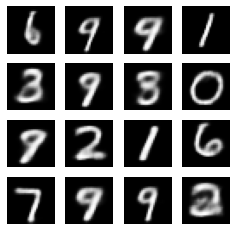

In [14]:
vae.train(train_dataset, test_dataset, epochs, batch_size)